![title](img/A_Pytorch_Workflow.png)

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [4]:
import torch
from torch import nn #nn contains all of pytorch's building blocks for neural nets
import matplotlib.pyplot as plt

torch.__version__

Matplotlib is building the font cache; this may take a moment.


'2.4.1'

## (1) Data (preparing and loading)

linear reg to create the data with known parameters and then pytorch to see if we can build model to estimate these paramters using gradient descent

In [5]:
weight=0.7
bias=0.3

start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X + bias
X[:10],y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [7]:
#train test split
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [8]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """

    plt.figure(figsize=(10,7))

    plt.scatter(train_data,train_labels,c="b",s=4,label="training data")

    plt.scatter(test_data,test_labels,c="g",label="testing data")

    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",label="predictions")

    plt.legend(prop={"size":14})

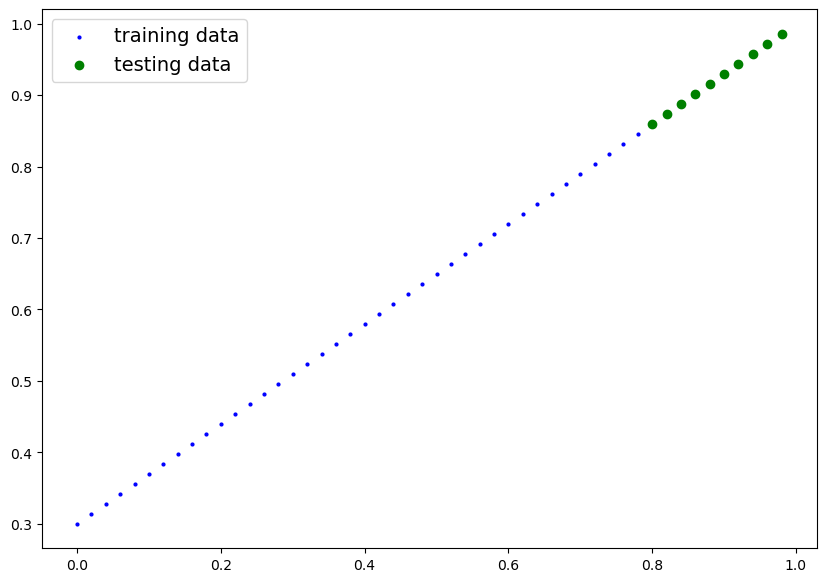

In [9]:
plot_predictions()

## (2) Build a Model

In [11]:
class LinearRegressionModel(nn.Module):  #almost everything in pytorch is a nn module
    def __init__(self):
        super().__init__()
        self.weights=nn.Parameter(torch.randn(1, #start with random weights
                                              dtype=torch.float),
                                  requires_grad=True #can we update this value with gradient descent
                                              )
        
        self.bias=nn.Parameter(torch.randn(1,
                                           dtype=torch.float),
                                           requires_grad=True
                                           )
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.weights*x+self.bias

pytorch model building essentials  
(1)torch.nn -> contains all the building blocks for computational graphs (essentailly a series of computations executed in a particular way)  
  
(2)torch.nn.Parameter -> stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd"  
  
(3)torch.nn.Module -> The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in pytorch, your models should subclass nn.Module. Requires a forward() method to be implemented  
  
(4)torch.optim -> Contains various optimization algorithms(these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss) 
   
(5) def forward() -> All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (eg. the linear reg formula above)

In short,  

nn.Module -> contains the larger bulding blocks(layers)  
  
nn.Parameter -> contains the smaller parameters like weights and biases (put these together to make nn.Module (s))  
  
forward() -> tells the larger blocks to make calculations on inputs(tensors full of data) within nn.Module(s)  
  
torch.optim -> contains optimization methods on how to improve parameters within nn.Parameter to better represent the input data

![title](img/torch_nn.png)

In [13]:
torch.manual_seed(42)

model_0=LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
#making predictions

with torch.inference_mode(): #context manager, turns of a bunch of things..
    #like gradient tracking, which is necessary for trianing but not inference to make forwardpasses
    y_preds=model_0(X_test)

#torch.inference_mode() vs torch.no_grad()
    #-> the prior is faster and preferred

In [19]:
print(f"nimber of testing samples:{len(X_test)}")
print(f"Number of predictions made : {len(y_test)}")
print(f"predicted values:{y_preds}")

nimber of testing samples:10
Number of predictions made : 10
predicted values:tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


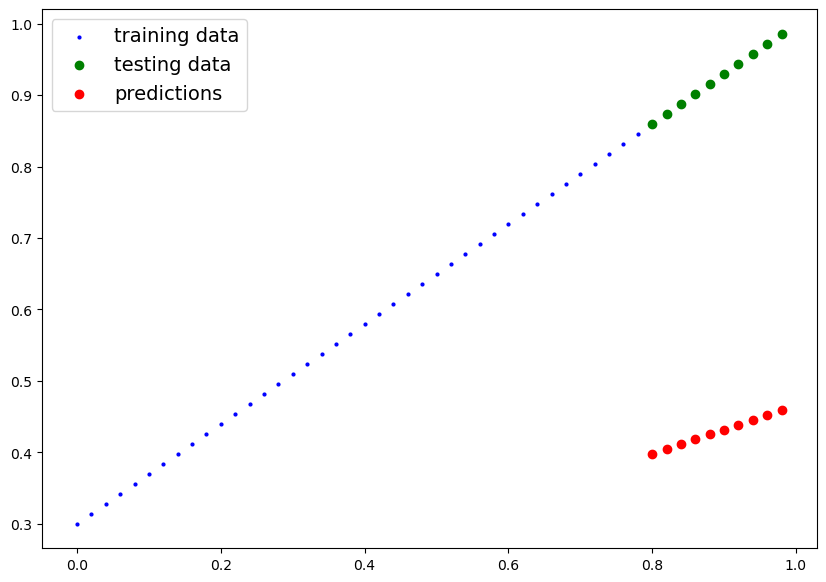

In [20]:
plot_predictions(predictions=y_preds)

In [21]:
y_test-y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## (3) Train model

(a) loss function -> lower the better. mae, torn.nn.L1Loss, binary cross entropy torch.nn.BCELoss()  
  
(b) optimizer -> tells your model how to update internal parameters to lower the loss - torch.optim - eg.torch.optim.SGD() , torch.optim.Adam()

In [22]:
loss_fn=nn.L1Loss() # Mae is the same as L1Loss

optimizer=torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                          lr=0.01 #learning rate
                          )

(a)training loop -> learning of relationships b/w features and labels  
  
(b)testing loop -> how good the patterns learnt are

![title](img/optimization_loop_song.png)

#### Pytorch training loop  
(1) Forward Pass -> model goes through all the training data at once, performing its forward() finction calculations. eg. model(x_train)  
  
(2)calculate the loss -> eg.loss=loss_fn(y_pred,y_train)  
  
(3)zero gradients -> optimizers gradients are set to zero so they can be recalculated for the specific training step eg.optimizer.zero_grad()  
  
(4)backprop on the loss -> compute gradient of the loss with respect to every model parameter to be updated(with requires_grad=True) eg. loss.backward()  
  
(5)update the optimizer (gradient descent) -> update the parameters with reuires_grad=True with respect ot the loss gradients in order to improve them eg.optimizer.step()

![title](img/pytorch_training_loop.png)

#### pytorch testing loop  
  
(1) Forward pass -> model goes through all of the testing data once, performing its forward() function calculations eg.model(x_test)  
  
(2)calculate the loss -> loss=loss_fn(y_pred,y_test)  
  
(3)evaluation metrics(optional) -> custom functions

(the testing loop does not perform backprop or stepping the optimizer, this is because no parameters are being altered during testing)

![title](img/pytorch_testing_loop.png)

In [25]:
torch.manual_seed(42)

epochs=100

train_loss_values=[]
test_loss_values=[]
epoch_count=[]


for epoch in range(epochs):
    ###Training

    #put model in training mode(default state of a model)
    model_0.train()

    #1.Forward pass using forward() method inside
    y_pred=model_0(X_train)

    #2.calcuate the loss
    loss=loss_fn(y_pred,y_train)

    #3.zero grad of the optimizer
    optimizer.zero_grad()

    #4.loss backwards
    loss.backward()

    #5.progress the optimizer
    optimizer.step()


    ###Testing

    #put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
        #1.Forward pass on the test data
        test_pred=model_0(X_test)

        #2.Calcualate the loss on test data
        test_loss=loss_fn(test_pred,y_test.type(torch.float)) ## predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        #print out what's happening

        if epoch%10==0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch:{epoch} | MAE train loss:{loss} | MAE test loss:{test_loss}")




Epoch:0 | MAE train loss:0.024458957836031914 | MAE test loss:0.05646304413676262
Epoch:10 | MAE train loss:0.021020209416747093 | MAE test loss:0.04819049686193466
Epoch:20 | MAE train loss:0.01758546754717827 | MAE test loss:0.04060482233762741
Epoch:30 | MAE train loss:0.014155392535030842 | MAE test loss:0.03233227878808975
Epoch:40 | MAE train loss:0.010716588236391544 | MAE test loss:0.024059748277068138
Epoch:50 | MAE train loss:0.0072835348546504974 | MAE test loss:0.016474086791276932
Epoch:60 | MAE train loss:0.003851778106763959 | MAE test loss:0.008201557211577892
Epoch:70 | MAE train loss:0.00893248151987791 | MAE test loss:0.005023092031478882
Epoch:80 | MAE train loss:0.00893248151987791 | MAE test loss:0.005023092031478882
Epoch:90 | MAE train loss:0.00893248151987791 | MAE test loss:0.005023092031478882


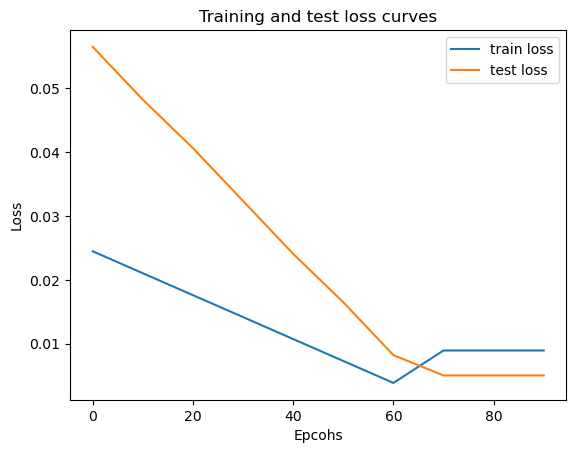

In [26]:
plt.plot(epoch_count,train_loss_values,label="train loss")
plt.plot(epoch_count,test_loss_values,label="test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epcohs")
plt.legend()


In [27]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### (4) Making predictions with a trained pytorch model  
  
(1)set the model in evaluation mode (model.eval())  
  
(2)make the predictions using the inference mode cotext manager (with torch.inference_mode())  
  
(3)All predictions should be made with objects on the same device(data & model on GPU only or on CPU only)


In [28]:
#1. Set the model in evaluation mode
model_0.eval()

#2.Setup the inference mode with context manager
with torch.inference_mode():
     # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
    y_preds=model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

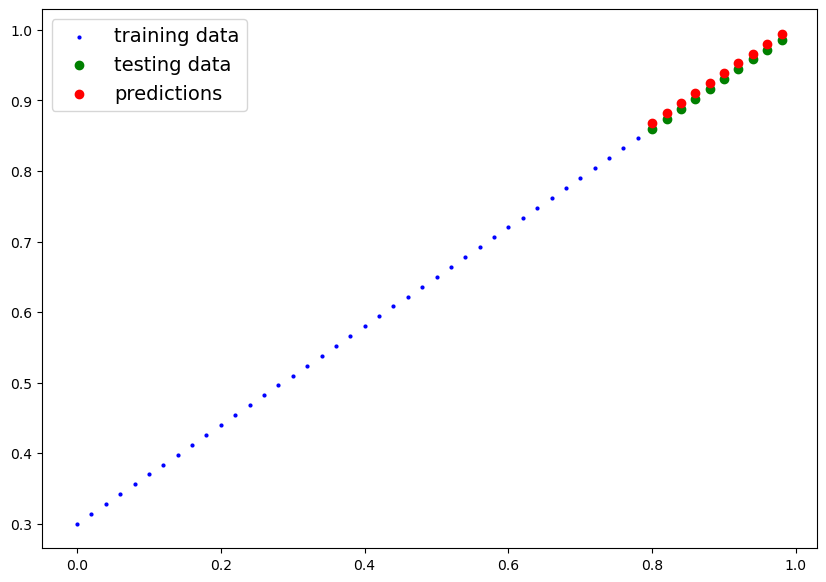

In [29]:
plot_predictions(predictions=y_preds)

### (5) Saving and loading a pytorch model   
  
to save it and export it elsewhere  
save your progress on a model and come back & load it later  
  
(1)torch.save -> saves a serialized object to disk using python's pickle utility. Models, tensors and various python objects like dictionaries can be saved using torch.save  
  
(2)torch.load -> uses pickle's unpickling features to deserialize and load pickled python object files(like models, tensors or dictionaries) into memory. you can also set which device to load the object to (CPU,GPU etc)  
  
(3)torch.nn.Module.load_state_dict-> loads a model's parameter dictionary(model.state_dict()) using a saved state_dict() object

 warning: the pickle module is not secure

#### Saving a pytorch's model's state_dict()  


In [31]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


In [32]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r--@ 1 kabirjamadar  staff  1680 Sep  7 18:19 models/01_pytorch_workflow_model_0.pth


##### Loading a saved pytorch model's state_dict()

Why not save the entire model and not just the state_dict()??  
The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

Because of this, your code can break in various ways when used in other projects or after refactors.




So instead, using the flexible method of saving and loading just the state_dict() (dictionary of model's parameters)

In [33]:
loaded_model_0=LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/var/folders/7j/6p_pd3gd44zfw3nn6n10_pnh0000gn/T/ipykernel_7232/1982428887.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MO

<All keys matched successfully>

In [34]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds=loaded_model_0(X_test)

In [35]:
y_preds==loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together

In [36]:
import torch
from torch import nn #nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt


torch.__version__

'2.4.1'

In [41]:
device=(
    "cuda" if torch.cuda.is_available() 
    else "mps" 
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

In [43]:
#data

weight=0.7
bias=0.3

start=0
end=1
step=0.02

X=torch.arange(start,end,step).unsqueeze(1)
y=weight*X+bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [44]:
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(X_test)

(40, 10)

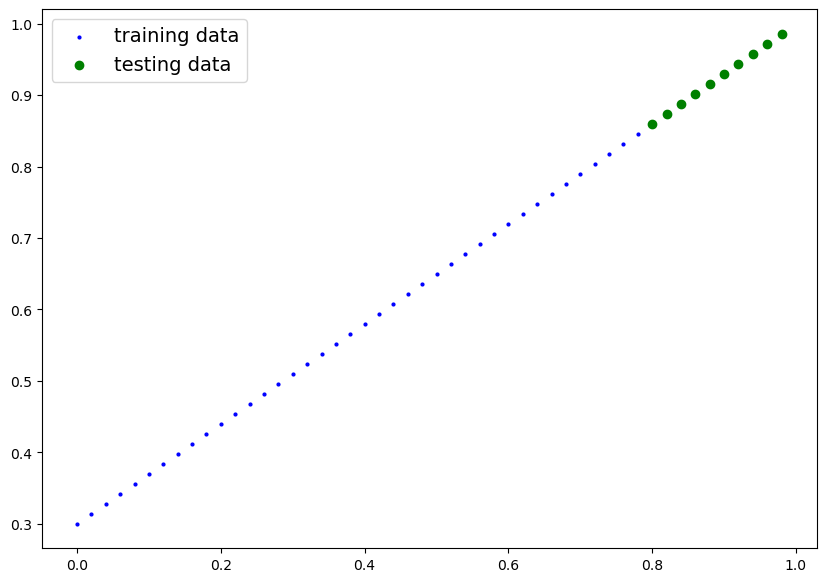

In [45]:
plot_predictions(X_train,y_train,X_test,y_test)

instead of defining the weight and bias parameters of our model manually using nn.Parameter(), now, use of nn.Linear(in_features,out_features)  

in_features->number of dimensions the input data has  
out_features -> number of dimensions you'd like the output to be 

![title](img/lr_with_nnparam.png)

In [48]:
#subclass of nn.Module to make our model 
class LinearRegressionModeleV2(nn.Module):
    def __init__(self):
        super().__init__()
        #use nn.Linear() to create model params

        self.linear_layer=nn.Linear(in_features=1,out_features=1)

    #forward computation(input data x flows through nn.Linear())

    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

#set manual seed
torch.manual_seed(42)
model_1=LinearRegressionModeleV2()
model_1,model_1.state_dict()
#nn.Linear() creates random weights and bias parameter

(LinearRegressionModeleV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [49]:
next(model_1.parameters()).device

device(type='cpu')

In [50]:
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [52]:
#training
loss_fn=nn.L1Loss()

#optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.01)


In [53]:
torch.manual_seed(42)

epochs=1000

#need to put data on this available device

X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)


for epoch in range(epochs):

    #training 

    model_1.train()

    #1.forward pass
    y_pred=model_1(X_train)

    #2.calculate the loss
    loss=loss_fn(y_pred,y_train)

    #3.zero grad optimizer
    optimizer.zero_grad()

    #4.loss backward
    loss.backward()

    #5.step the optimizer
    optimizer.step()


    ##Testing

    model_1.eval()

    #1.Forward pass
    with torch.inference_mode():
        test_pred=model_1(X_test)

        #2.loss
        test_loss=loss_fn(test_pred,y_test)

    if epoch%100==0:
        print(f"Epoch:{epoch} | Train loss:{loss} | Test loss:{test_loss}")





Epoch:0 | Train loss:0.5551779270172119 | Test loss:0.5739762783050537
Epoch:100 | Train loss:0.0062156799249351025 | Test loss:0.014086711220443249
Epoch:200 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:300 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:400 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:500 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:600 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:700 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:800 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904
Epoch:900 | Train loss:0.0012645028764382005 | Test loss:0.013801807537674904


In [54]:
from pprint import pprint

print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [56]:
# making predictions

model_1.eval()

with torch.inference_mode():
    y_preds=model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

many ds libraries like pandas, numpy, maatplotlib are not capable of using data stored on GPU. so convert to cput

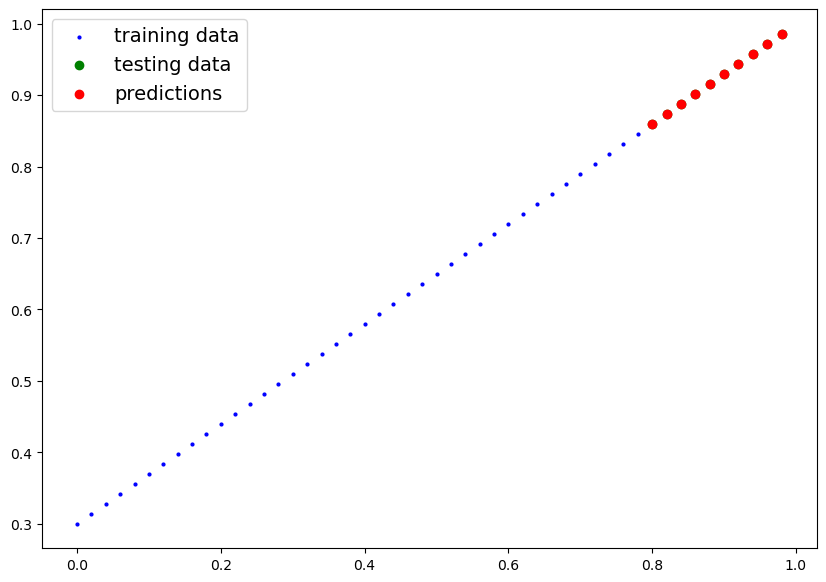

In [57]:
plot_predictions(predictions=y_preds.cpu())

In [58]:
#saving and loading a model

from pathlib import Path

#1.Create models dir

MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#2.create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [59]:
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [63]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModeleV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModeleV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


/var/folders/7j/6p_pd3gd44zfw3nn6n10_pnh0000gn/T/ipykernel_7232/4075651857.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODE

In [64]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')